In [1]:
import numpy as np
import scipy.special as ss
import matplotlib.pyplot as plt
from numpy import pi as PI

## Exercise 2.1: RCS of Sphere and Corner Reflector

In [2]:
def RCS_sphere_approx(size, freq): # size as radius of sphere
    wave_speed = 299792458 # is the speed of light; 299,792,458 metres per second (https://en.wikipedia.org/wiki/Speed_of_light)
    # when we have sphere in square meters then also the light travelling is in meters per seconds
    my_lambda = wave_speed/freq # assuming that the that unit of freq is 1/second

    if (2  * size * PI) >= my_lambda:
        return   ((size**2) * PI) # RCS approx
    else:
        return (9 * (((2 * 1 / my_lambda) * size)**4) * (size**2) * PI)


In [3]:
def RCS_corner_reflector_approx(size, freq): # size as side length of corner reflector
    wave_speed = 299792458 
    my_lambda = wave_speed/freq 
    
    if 3*my_lambda<size:
        return 4 * PI * size**4/(3*my_lambda**2)
    else:
        return np.nan 

In [4]:
def RCS_sphere_exact(size, freq):
    wave_speed = 299792458 
    my_lambda = wave_speed/freq 
    kr = (2 * PI / my_lambda) * size

    J_nMinusOne = ss.spherical_jn(n=0, z=kr)
    H_nMinusOne = ss.hankel1(0, kr)

    sum_part = 0

    for n in range(1,101):

        J_n = ss.spherical_jn(n=n, z=kr) # n has to be >= 0
        H_n = ss.hankel1(n, kr)
        sum_part += ((-1)**n) * (2 * n + 1) * (((kr * J_nMinusOne - n * J_n) / (kr * H_nMinusOne - n * H_n)) - (J_n / H_n))

        J_nMinusOne = J_n
        H_nMinusOne = H_n

    intermed_result = (np.imag(1j)/kr) * sum_part
    intermed_result = (intermed_result.real**2) + (intermed_result.imag**2)
    return intermed_result * PI * (size**2)

## Homework 2.1: Compare RCS of a Sphere and a Corner Reflector

/home/c/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


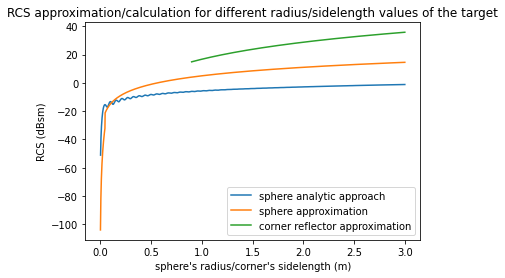

In [5]:
wave_speed = 299792458 
f_c = 10**9
my_lambda = wave_speed/f_c

# if you want so:
sphere_approx_collection = []
corner_collection = []
sphere_exact_collection = []

size_ar = []
for i in range(1,3000):
    size = i/1000
    size_ar.append(size)
    
    sphere_approx = RCS_sphere_approx(size,f_c)
    sphere_approx_collection.append(sphere_approx)
    
    corner = RCS_corner_reflector_approx(size,f_c)
    corner_collection.append(corner)

    sphere_exact = RCS_sphere_exact(size,f_c)
    sphere_exact_collection.append(sphere_exact)
    
# dBsm means simply db(m**2), sm for square meters (https://www.testandmeasurementtips.com/understanding-decibels-and-decibel-measurements-faq/).    
# Therefore, we only have to convert the linear values into dB using log:
to_plot_sphere_exact = 10*np.log10(sphere_exact_collection)
# checked for correction via https://www.rozendalassociates.com/rcs-interpretation 
# where 100 m**2 are 20 dBsm
to_plot_corner = 10*np.log10(corner_collection)
to_plot_sphere_approx = 10*np.log10(sphere_approx_collection)


size_ar = np.array(size_ar)
mask = np.where((size_ar>=my_lambda*0.01) & (size_ar<=my_lambda*10))

plt.plot(size_ar[mask],to_plot_sphere_exact[mask])
plt.plot(size_ar[mask],to_plot_sphere_approx[mask])
plt.plot(size_ar[mask],to_plot_corner[mask])
plt.legend(['sphere analytic approach','sphere approximation','corner reflector approximation'])
plt.title('RCS approximation/calculation for different radius/sidelength values of the target')
plt.xlabel('sphere\'s radius/corner\'s sidelength (m)')
plt.ylabel('RCS (dBsm)')
plt.show()

- Because the signal gets better catched in by the reflector and then the same direction reflected back as it came. 
- When the frequency is too low (considering the x-axis boundaries as in the task given), then the corner reflector can't handle it anymore and has therefore only nan values to return. With even lower frequency the sphere exact calculation of RCS also struggles and with increasing frequency values its RCS value lowers a bit with increasing radius. The rest stays stable and the corner reflector reaches for its RCS higher scores. 
- Of the computation time changes with the number of iterations (increasing). Besides that, having a low number of iterations, like 2, the RCS values fall into negative direction with increasing sphere's radius. However, with a high number of iterations, like 1000, the Bessel function will simply become 0 and the Hankel function can't handle the high iteration number anymore (nan values). Therefore, for very high number of iterations the RCS isn't computable.

## Homework 2.2: Radar Equation with Simple Objects

In [6]:
Pt_dBm=1.0        # transmit power
Gt_dB=15.0        # gain of the TX antenna
Gr_dB=15.0        # gain of the RX antenna
Pr_min_dBm=-120.  # minimal required power at the receiver
# bring it to -120-1=-121 dB when we take it as ratio to 1 dB (https://www.onesdr.com/db-to-dbm-calculator/)
fc=77e9           # carrier frequency

In [7]:
def dBm2dB(dbm_val):
    b_mW = 10**(dbm_val/10) # of log_a (b) = x
    b_W = b_mW * 1e-3
    
    db = 10*np.log10(b_W)
    return db

In [8]:
Pr_min_dB = dBm2dB(Pr_min_dBm)
Pt_dB = dBm2dB(Pt_dBm)

In [9]:
# aim: plotting receive power
wave_speed = 299792458 
my_lambda = wave_speed/fc

pr_corner_ar = np.zeros((4,(300-10+1)))
pr_approx_ar = np.zeros((4,(300-10+1)))
pr_exact_ar = np.zeros((4,(300-10+1)))

for ind_a, a in enumerate([2.0, 1.0, 0.1, 0.01]): # as radius sphere/sidelength corner reflector; assuming unit meters
    RCS_corner = RCS_corner_reflector_approx(a,fc)
    RCS_sphere_approx_var = RCS_sphere_approx(a,fc)
    RCS_sphere_exact_var = RCS_sphere_exact(a,fc)

    for distance in range(10,301):

        Pr_dB_corner = Pt_dB + Gt_dB + Gr_dB + 20*np.log10(my_lambda) + 10*np.log10(RCS_corner) - 30*np.log10(4*PI) - 40*np.log10(distance)
        Pr_dB_approx = Pt_dB + Gt_dB + Gr_dB + 20*np.log10(my_lambda) + 10*np.log10(RCS_sphere_approx_var) - 30*np.log10(4*PI) - 40*np.log10(distance)
        Pr_dB_exact = Pt_dB + Gt_dB + Gr_dB + 20*np.log10(my_lambda) + 10*np.log10(RCS_sphere_exact_var) - 30*np.log10(4*PI) - 40*np.log10(distance)
        
        ind_d = distance-10
        pr_corner_ar[ind_a,ind_d] = Pr_dB_corner
        pr_approx_ar[ind_a,ind_d] = Pr_dB_approx
        pr_exact_ar[ind_a,ind_d] = Pr_dB_exact

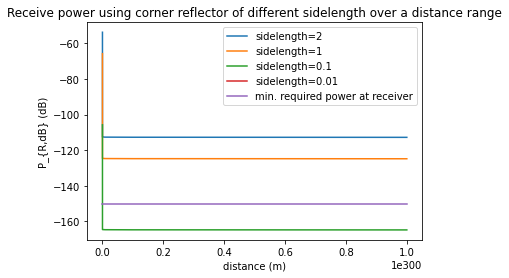

In [10]:
x_axis = np.logspace(10,300,num=pr_corner_ar.shape[1])

plt.plot(x_axis,pr_corner_ar[0])
plt.plot(x_axis,pr_corner_ar[1])
plt.plot(x_axis,pr_corner_ar[2])
plt.plot(x_axis,pr_corner_ar[3])

plt.plot(x_axis,[Pr_min_dB for i in range(len(x_axis))])


plt.legend(['sidelength=2','sidelength=1','sidelength=0.1', 'sidelength=0.01','min. required power at receiver'])
plt.title('Receive power using corner reflector of different sidelength over a distance range')
plt.xlabel('distance (m)')
plt.ylabel('P_{R,dB} (dB)')
plt.show()

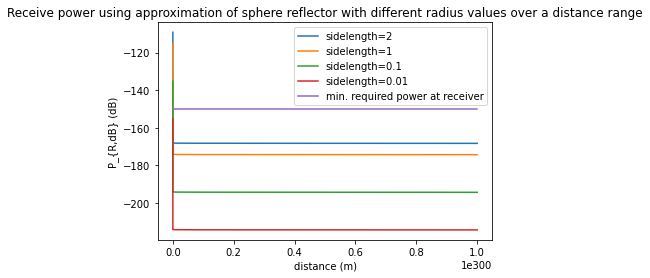

In [11]:
plt.plot(x_axis,pr_approx_ar[0])
plt.plot(x_axis,pr_approx_ar[1])
plt.plot(x_axis,pr_approx_ar[2])
plt.plot(x_axis,pr_approx_ar[3])

plt.plot(x_axis,[Pr_min_dB for i in range(len(x_axis))])


plt.legend(['sidelength=2','sidelength=1','sidelength=0.1', 'sidelength=0.01','min. required power at receiver'])
plt.title('Receive power using approximation of sphere reflector with different radius values over a distance range')
plt.xlabel('distance (m)')
plt.ylabel('P_{R,dB} (dB)')
plt.show()

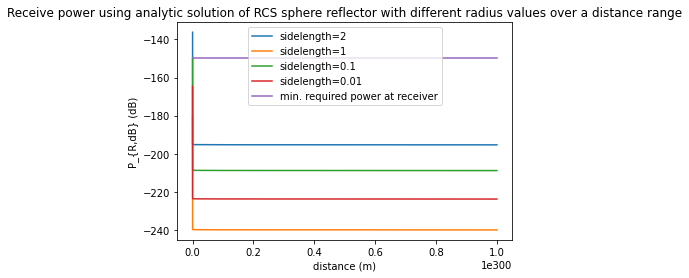

In [12]:
plt.plot(x_axis,pr_exact_ar[0])
plt.plot(x_axis,pr_exact_ar[1])
plt.plot(x_axis,pr_exact_ar[2])
plt.plot(x_axis,pr_exact_ar[3])

plt.plot(x_axis,[Pr_min_dB for i in range(len(x_axis))])

plt.legend(['sidelength=2','sidelength=1','sidelength=0.1', 'sidelength=0.01','min. required power at receiver'])
plt.title('Receive power using analytic solution of RCS sphere reflector with different radius values over a distance range')
plt.xlabel('distance (m)')
plt.ylabel('P_{R,dB} (dB)')
#locs, labels=plt.xticks()
#x_ticks = []
#new_xticks= ['test' for d in locs]
#plt.xticks(locs,new_xticks, rotation=45, horizontalalignment='right')
plt.show()

Corner reflector: a sidelength of 0.01 m would be too small for any detection. Beyond that, we have a minimal required power at the receiver. All lines with higher values than that pass. Therefore, we can discover reflectors with sidelength of 2 and 1 meters. Also with 0.1 meters when distance lays around 10 meters.<br>
Approximation sphere reflector: here we aren't able in detecting the reflectors with exception that a radius of length 2, 1 and 0.1 meters and a distance around 10 meters are given.<br>
Analytic approach to sphere refelctor: When computing the RCS analytically, we get similar struggles. the reflector gets detected for sidelength of 2 meters and reflector distance around 10 meters.

## Homework 2.3: Distance for Pedestrian Classification

In [13]:
# aim: plotting receive power
wave_speed = 299792458 
my_lambda = wave_speed/fc

pr_human_ar = np.zeros((300-10+1))

RCS_human = 1
start_distance = 10
for distance in range(start_distance,301):

    Pr_dB_human = Pt_dB + Gt_dB + Gr_dB + 20*np.log10(my_lambda) + 10*np.log10(RCS_human) - 30*np.log10(4*PI) - 40*np.log10(distance)

    ind_d = distance-10
    
    pr_human_ar[ind_d] = Pr_dB_human


In [14]:
threshold = Pr_min_dB + 20
max_ind_detect = np.where(pr_human_ar>=threshold)[0][-1]
max_distance = max_ind_detect + start_distance
max_distance

17

When looking on the basis on meters then the variable max_distance tells us that we can detect a human when (s)he is max. 17 meters away.

## Homework 2.4: Corner Reflector on the Moon

In [15]:
R = 385000*1e3
a = 0.5

In [16]:
# a) Find transmit power
# In exercise it was said we could use the Airport Radar from the slides before.
SNR_dB = 10
G_T_dB = 44.15 
G_R_dB = 44.15
fc_airport = 10 * 1e9
my_lambda_airport = wave_speed/fc_airport

RCS_corner_moon = RCS_corner_reflector_approx(a, fc)

T = 290 
B_N = 1e9

k_B = 1.38 * 1e-23
P_N = 4 * k_B * T * B_N
P_N_dB = 10*np.log10(P_N)
P_R_dB = SNR_dB - P_N_dB

P_T_dB = P_R_dB - G_T_dB - G_R_dB - 20*np.log10(my_lambda_airport) - 10*np.log10(RCS_corner_moon) + 30*np.log10(4*PI) + 40*np.log10(R)
P_T_dB

394.14185357480665

The transmitter power should be of 394.14185357480665 dB.

In [17]:
# b) How much observation time do we need to detect corner reflector?
# The higher the observation time the lower the power of the noise. 
# according to exercise 2, page 6 the minium receiver power can be computed like this
#Pmin_R_dB = P_T_dB + G_T_dB + G_R_dB + 20*np.log10(my_lambda_airport) + 10*np.log10(RCS_corner_moon) - 30*np.log10(4*PI) - 40*np.log10(R)
# this is almost the same as P_R_dB .
# So we already have the minimal required which is calculated out of SNR and P_N. The P_N contains the
# variable of interest, T_obs. Simply split it up:
T_obs = 1/B_N
T_obs

1e-09

The observation time shall be around $10^{-9}$ seconds.

c) Is it feasible to use such a radar for this task? <br>
Answer: No, airport radars are designed for tracking planes. The tools for moon reflector observation are missing because the moon is far away and therefore also lots of noise can come up from the surrounding atmosphere.